In [1]:
import tensorflow as tf
import tensorflow.keras.applications as applications
import numpy as np
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Softmax
from tensorflow.keras.models import Model
import os
import json
from pathlib import Path
import pickle
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm
# Set random seed for reproducibility
tf.random.set_seed(107)
np.random.seed(107)

# Enable GPU memory growth to prevent allocation errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

2025-05-25 17:47:11.724992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748195231.900551      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748195231.949973      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
! pip install nltk

In [3]:
BASE_PATH = '../input/coco2017'
with open(f'{BASE_PATH}/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)

In [4]:
def display_sample(sample):
    image_path = sample['image']
    caption = sample['caption']
    
    im = Image.open(image_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(np.array(im))
    plt.axis('off')  # Hide axes
    plt.title(caption, pad=20)
    plt.show()

In [5]:
data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
captions['image'] = captions['image'].apply(
    lambda x: f'{BASE_PATH}/train2017/{x}'
)
df = captions.reset_index(drop=True)
df.head()

,image,caption
0,../input/coco2017/train2017/000000203564.jpg,A bicycle replica with a clock as the front wh...
1,../input/coco2017/train2017/000000322141.jpg,A room with blue walls and a white sink and door.
2,../input/coco2017/train2017/000000016977.jpg,A car that seems to be parked illegally behind...
3,../input/coco2017/train2017/000000106140.jpg,A large passenger airplane flying through the ...
4,../input/coco2017/train2017/000000106140.jpg,There is a GOL plane taking off in a partly cl...


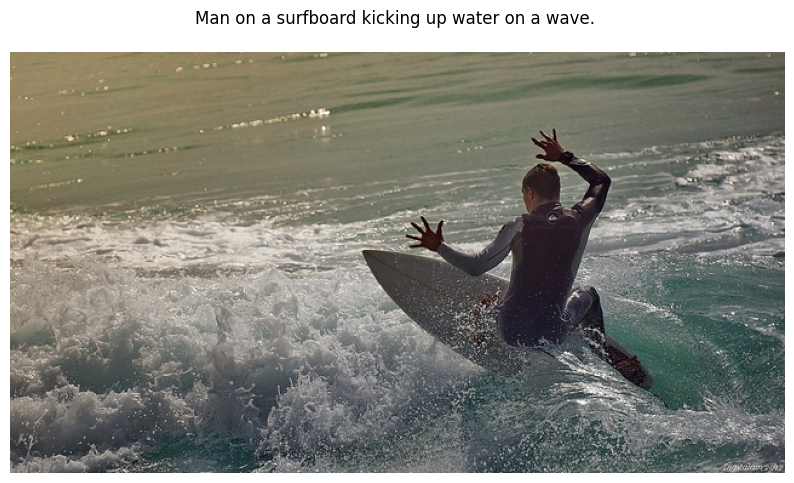

In [6]:
display_sample(df.sample().iloc[0])

# Vectorizing the text data

In [7]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)       #Remove Punctuation
    text = re.sub('\s+', ' ', text)           #Replace Multiple Spaces with Single Space
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [8]:
df['caption'] = df['caption'].apply(preprocess)
df.head()

,image,caption
0,../input/coco2017/train2017/000000203564.jpg,[start] a bicycle replica with a clock as the ...
1,../input/coco2017/train2017/000000322141.jpg,[start] a room with blue walls and a white sin...
2,../input/coco2017/train2017/000000016977.jpg,[start] a car that seems to be parked illegall...
3,../input/coco2017/train2017/000000106140.jpg,[start] a large passenger airplane flying thro...
4,../input/coco2017/train2017/000000106140.jpg,[start] there is a gol plane taking off in a p...


In [9]:
df['number_of_words'] = df['caption'].apply(lambda x: len(str(x).split()))
df.head()

,image,caption,number_of_words
0,../input/coco2017/train2017/000000203564.jpg,[start] a bicycle replica with a clock as the ...,12
1,../input/coco2017/train2017/000000322141.jpg,[start] a room with blue walls and a white sin...,13
2,../input/coco2017/train2017/000000016977.jpg,[start] a car that seems to be parked illegall...,15
3,../input/coco2017/train2017/000000106140.jpg,[start] a large passenger airplane flying thro...,10
4,../input/coco2017/train2017/000000106140.jpg,[start] there is a gol plane taking off in a p...,14


In [10]:
df.describe()

,number_of_words
count,591753.000000
mean,12.454947
std,2.392038
min,7.000000
25%,11.000000
50%,12.000000
75%,13.000000
max,51.000000


by this we ensure that longest sentence length is 51

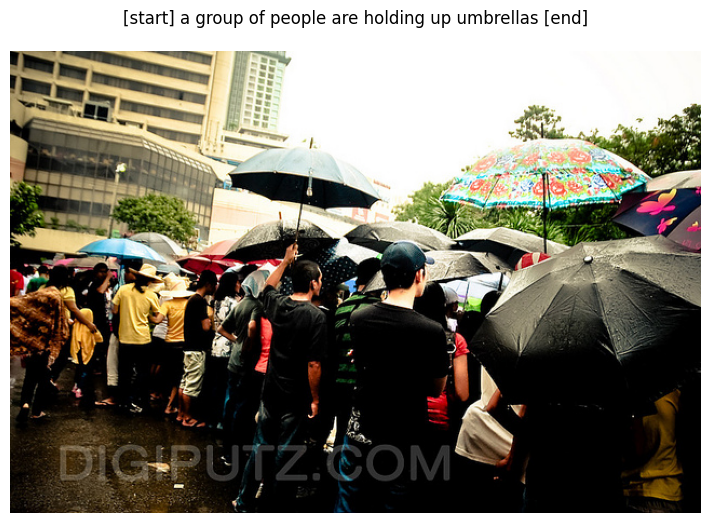

In [11]:
display_sample(df.sample().iloc[0])

In [12]:
MAX_LENGTH = 52
VOCABULARY_SIZE = 10000
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

In [13]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    output_mode="int",
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(df['caption'])

I0000 00:00:1748195258.009982      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [14]:
tokenizer.vocabulary_size()

10000

In [15]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

# Building a tf.data.Dataset pipeline for training

In [16]:
captions = df.sample(100000)
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)


In [17]:
multi_cap_images = {img: caps for img, caps in img_to_cap_vector.items() if len(caps) > 1}
sampled_image = random.sample(list(multi_cap_images.items()), 1)
sampled_image

[('../input/coco2017/train2017/000000102056.jpg',
  ['[start] a group of people standing outside of a small bus [end]',
   '[start] a group of skiers boarding a bus with their skis [end]'])]

thats mean this is image have more than one caption 

In [18]:
#split the data
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index], 
                                          img_keys[slice_index:])
# extent image so that each img have a caption
train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [19]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(80037, 80037, 19963, 19963)

# create dataset

In [20]:
def load_data(img_path, caption):
    # Load and preprocess image
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(224, 224)(img)
    img = tf.cast(img, tf.float32) / 255.0  # Normalize pixel values
    
    # Tokenize caption
    caption_tokens = tokenizer(caption)
    
    # Create input and target sequences for teacher forcing
    input_tokens = caption_tokens[:-1]  # All tokens except last
    target_tokens = caption_tokens[1:]  # All tokens except first
    
    return (img, input_tokens), target_tokens

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=AUTOTUNE
    ).shuffle(BATCH_SIZE*8).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=AUTOTUNE
    ).shuffle(BATCH_SIZE*8).batch(BATCH_SIZE)

# model

first just testing each block and see their output

In [22]:
def get_cnn_model():
    base_model = applications.MobileNetV3Large(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False,
        include_preprocessing=True
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = tf.keras.layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    print(base_model_out.shape[-1])
    cnn_model = tf.keras.models.Model(base_model.input, base_model_out)
    return cnn_model

sample_batch = next(iter(train_dataset))
(inputs, targets) = sample_batch
img_batch, input_token_batch = inputs

cnn_model = get_cnn_model()
features = cnn_model(img_batch)

print("CNN Output Shape:", features.shape)  #  (batch_size, L, D).

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
960


I0000 00:00:1748195267.960990      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


CNN Output Shape: (16, 49, 960)


In [23]:
avg_features = tf.reduce_mean(features, axis=1)
avg_features.shape

TensorShape([16, 960])

In [24]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, attention_units):
        super(Attention, self).__init__()
        self.Wa = Dense(attention_units)
        self.Ua = Dense(attention_units)
        self.Va = Dense(1)

    def call(self, features, hidden):
        # features: (batch, L, D), hidden: (batch, hidden_size)
        score = self.Va(tf.nn.tanh(self.Wa(features) + self.Ua(hidden)[:, tf.newaxis, :]))  # (batch, L, 1)
        attention_weights = tf.nn.softmax(score, axis=1)  # (batch, L, 1)
        context_vector = tf.reduce_sum(attention_weights * features, axis=1)  # (batch, D)
        return context_vector

attention_layer = Attention(attention_units=512)
avg_features = tf.reduce_mean(features, axis=1)

state_init_h = Dense(512, activation='tanh')
h0 = state_init_h(avg_features)

context= attention_layer(features, h0)
print("Context Vector Shape:", context.shape)

Context Vector Shape: (16, 960)


# build Model

In [25]:
def get_cnn_model():
    base_model = applications.MobileNetV3Large(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False,
        include_preprocessing=True  
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = tf.keras.layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = tf.keras.models.Model(base_model.input, base_model_out)
    return cnn_model
    
class Attention(tf.keras.layers.Layer):
    def __init__(self, attention_units):
        super(Attention, self).__init__()
        self.Wa = Dense(attention_units)
        self.Ua = Dense(attention_units)
        self.Va = Dense(1)

    def call(self, features, hidden):
        # features: (batch, L, D), hidden: (batch, hidden_size)
        score = self.Va(tf.nn.tanh(self.Wa(features) + self.Ua(hidden)[:, tf.newaxis, :]))  # (batch, L, 1)
        attention_weights = tf.nn.softmax(score, axis=1)  # (batch, L, 1)
        context_vector = tf.reduce_sum(attention_weights * features, axis=1)  # (batch, D)
        return context_vector

class DecoderWithAttention(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, attention_units, vocab_size, max_length):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.max_length = max_length
        self.attention = Attention(attention_units)
        self.lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)
        self.output_layer = Dense(vocab_size, activation='softmax')
        self.state_init_h = Dense(hidden_dim, activation='tanh')
        self.state_init_c = Dense(hidden_dim, activation='tanh')
        self.context_proj = Dense(hidden_dim)

    def call(self, inputs):
        features, embedding = inputs
        
        # Initialize states
        avg_features = tf.reduce_mean(features, axis=1)
        h0 = self.state_init_h(avg_features)
        c0 = self.state_init_c(avg_features)
        
        outputs = []
        hidden = h0
        cell = c0
        
        for t in range(self.max_length):
            context = self.attention(features, hidden)
            context = self.context_proj(context)
            input_t = embedding[:, t, :] + context
            
            # LSTM step
            output, hidden, cell = self.lstm(
                tf.expand_dims(input_t, 1),
                initial_state=[hidden, cell]
            )
            outputs.append(self.output_layer(output[:, 0, :]))
            
        return tf.stack(outputs, axis=1)

def build_model(vocab_size, max_length=52, hidden_dim=512, attention_units=512):
    encoder = get_cnn_model()
    
    # Inputs
    image_input = Input(shape=(224, 224, 3))
    caption_input = Input(shape=(max_length,))
    
    # Encoder
    features = encoder(image_input)
    
    # Embedding
    embedding = Embedding(vocab_size, hidden_dim)(caption_input)
    
    # Decoder
    decoder = DecoderWithAttention(hidden_dim, attention_units, vocab_size, max_length)
    outputs = decoder([features, embedding])
    
    return Model(inputs=[image_input, caption_input], outputs=outputs)
model = build_model(VOCABULARY_SIZE, max_length=51, hidden_dim=512, attention_units=512)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 51)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 49, 960)        │      2,996,352 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 51, 512)        │      5,120,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_with_attention    │ (None, 51, 10000)      │      9,460,497 │ functional_1[0][0],    │
│ (DecoderWithAttention)    │                        │                │ embedding[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 17,576,849 (67.05 MB)

 Trainable params: 14,580,497 (55.62 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [26]:
# Custom loss function to mask padding tokens
def masked_loss(y_true, y_pred):
    mask = tf.cast(y_true != 0, tf.float32)  # Ignore <pad> (0)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)
    return tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)

optimizer = tf.keras.optimizers.Adam(learning_rate=4e-4)
# Compile model with custom loss
model.compile(optimizer=optimizer, loss=masked_loss, metrics=['accuracy'])

In [27]:
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tensorflow.keras.callbacks import Callback

class BLEUCallback(Callback):
    def __init__(self, val_data, tokenizer, idx2word, max_length=51, sample_size=1000):
        super().__init__()
        self.val_data = val_data
        self.tokenizer = tokenizer
        self.idx2word = idx2word
        self.max_length = max_length
        self.sample_size = sample_size
        self.smoothie = SmoothingFunction().method4
        self.bleu_scores = []

    def on_epoch_end(self, epoch, logs=None):
        bleu_score = self.evaluate_bleu(self.model)
        self.bleu_scores.append(bleu_score)
        print(f"\nEpoch {epoch+1} BLEU-4 Score: {bleu_score:.4f}")

    def evaluate_bleu(self, model):
        references = []
        hypotheses = []

        for (img, input_caption), target_caption in self.val_data.unbatch().take(100):
            # Generate prediction
            img = tf.expand_dims(img, axis=0)
            predicted = self.generate_caption_from_tensor(img, model)

            # Get reference
            ref = [
                self.idx2word(wid).numpy().decode("utf-8")
                for wid in target_caption
                if wid != 0
            ]
            if '[start]' in ref: ref.remove('[start]')
            if '[end]' in ref: ref.remove('[end]')

            references.append([ref])
            hypotheses.append(predicted.split())

        bleu4 = corpus_bleu(references, hypotheses, smoothing_function=self.smoothie)
        return bleu4

    def generate_caption_from_tensor(self, img_tensor, model):
        caption = [self.tokenizer.get_vocabulary().index('[start]')]
        for _ in range(self.max_length):
            cap_input = tf.keras.preprocessing.sequence.pad_sequences(
                [caption], maxlen=self.max_length, padding='post')
            cap_input = tf.convert_to_tensor(cap_input, dtype=tf.int32)

            preds = model([img_tensor, cap_input], training=False)
            pred_id = tf.argmax(preds[0, len(caption)-1, :]).numpy()
            caption.append(pred_id)

            if pred_id == self.tokenizer.get_vocabulary().index('[end]'):
                break

        words = [
            self.idx2word(tf.constant([tid])).numpy()[0].decode("utf-8")
            for tid in caption[1:-1]
        ]
        return ' '.join(words)


In [29]:
bleu_callback = BLEUCallback(
    val_data=val_dataset,
    tokenizer=tokenizer,
    idx2word=idx2word,
    max_length=51,
    sample_size=50  
)

In [30]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    # callbacks=[bleu_callback]
)

Epoch 1/10
5003/5003 ━━━━━━━━━━━━━━━━━━━━ 937s 175ms/step - accuracy: 0.0648 - loss: 4.4604 - val_accuracy: 0.0856 - val_loss: 3.4289
Epoch 2/10
5003/5003 ━━━━━━━━━━━━━━━━━━━━ 875s 175ms/step - accuracy: 0.0879 - loss: 3.2903 - val_accuracy: 0.0914 - val_loss: 3.1675
Epoch 3/10
5003/5003 ━━━━━━━━━━━━━━━━━━━━ 874s 175ms/step - accuracy: 0.0937 - loss: 2.9954 - val_accuracy: 0.0941 - val_loss: 3.0637
Epoch 4/10
5003/5003 ━━━━━━━━━━━━━━━━━━━━ 873s 174ms/step - accuracy: 0.0972 - loss: 2.8162 - val_accuracy: 0.0951 - val_loss: 3.0277
Epoch 5/10
5003/5003 ━━━━━━━━━━━━━━━━━━━━ 875s 175ms/step - accuracy: 0.0999 - loss: 2.6801 - val_accuracy: 0.0957 - val_loss: 3.0125
Epoch 6/10
5003/5003 ━━━━━━━━━━━━━━━━━━━━ 874s 175ms/step - accuracy: 0.1026 - loss: 2.5642 - val_accuracy: 0.0959 - val_loss: 3.0067
Epoch 7/10
5003/5003 ━━━━━━━━━━━━━━━━━━━━ 875s 175ms/step - accuracy: 0.1053 - loss: 2.4603 - val_accuracy: 0.0957 - val_loss: 3.0257
Epoch 8/10
5003/5003 ━━━━━━━━━━━━━━━━━━━━ 872s 174ms/step - ac

In [31]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy metrics
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

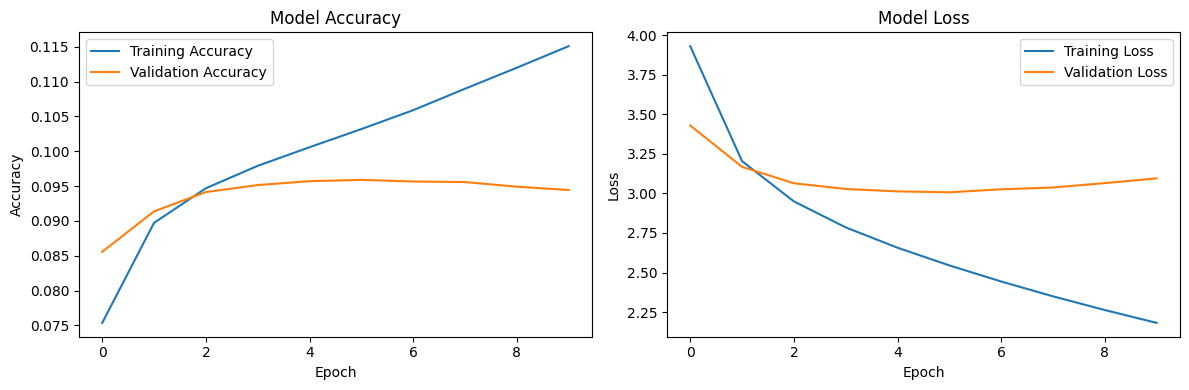

In [32]:
plot_training_history(history)

In [33]:
print("FINISHING TRAINING")

FINISHING TRAINING


In [34]:
def generate_caption(image_path, model, max_length=51):
    # Load and preprocess image
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(224, 224)(img)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, 0)  # Add batch dimension
    
    # Initialize caption with start token
    caption = [tokenizer.get_vocabulary().index('[start]')]
    
    for _ in range(max_length):
        # Prepare input sequence
        caption_input = tf.keras.preprocessing.sequence.pad_sequences(
            [caption], maxlen=max_length, padding='post'
        )
        caption_input = tf.convert_to_tensor([caption_input], dtype=tf.int32)
        caption_input = tf.squeeze(caption_input, 0) if caption_input.shape[0] == 1 else caption_input
        # Get predictions
        predictions = model([img, caption_input], training=False)
        predicted_id = tf.argmax(predictions[0, len(caption)-1, :]).numpy()
        
        # Append predicted word
        caption.append(predicted_id)
        
        # Stop if end token is predicted
        if predicted_id == tokenizer.get_vocabulary().index('[end]'):
            break
    
    # Convert token IDs to words
    words = []
    for token_id in caption[1:-1]:  # Exclude [start] and [end]
        word = idx2word(tf.constant([token_id])).numpy()[0].decode('utf-8')
        words.append(word)
    
    return ' '.join(words)

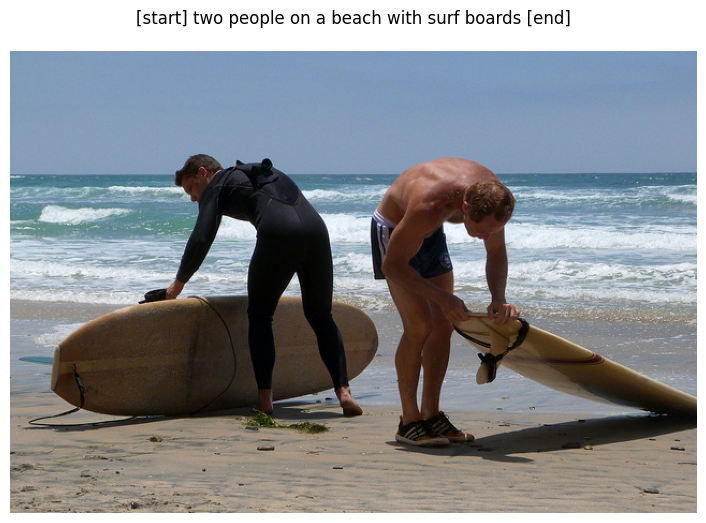

In [35]:
sample = df.sample().iloc[0]
display_sample(sample)

In [36]:
test_image_path = sample['image']
caption = generate_caption(test_image_path, model)
print(f'Generated Caption: {caption}')

Generated Caption: a man is standing on a beach with a surfboard


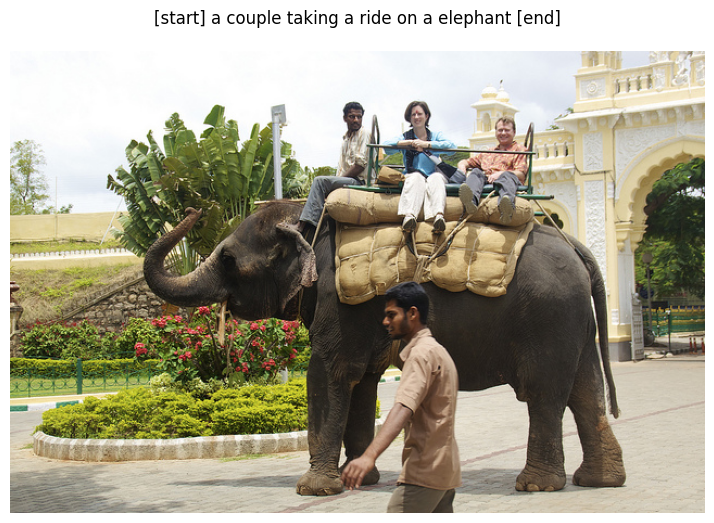

In [37]:
sample = df.sample().iloc[0]
display_sample(sample)

In [38]:
test_image_path = sample['image']
caption = generate_caption(test_image_path, model)
print(f'Generated Caption: {caption}')

Generated Caption: a group of people standing in front of a building


In [39]:
# Save final model
model.save_weights('/kaggle/working/final_model.weights.h5')

In [40]:
val_bleu = bleu_callback.evaluate_bleu(model)
print(f"\nPost-training BLEU-4 Score: {val_bleu:.4f}")


Post-training BLEU-4 Score: 0.0258
